In [1]:
import os 
import glob
from rtmag.paper.load import load_input_label, MyModel
import matplotlib.pyplot as plt
from sunpy.map import Map
import numpy as np
import rtmag.paper.metric as m

In [2]:
data_path = "/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/12673/hmi"
hmi_p_files = sorted(glob.glob(os.path.join(data_path, '*Bp.fits')))  # x
hmi_t_files = sorted(glob.glob(os.path.join(data_path, '*Bt.fits')))  # y
hmi_r_files = sorted(glob.glob(os.path.join(data_path, '*Br.fits')))  # z
data_paths = list(zip(hmi_p_files, hmi_t_files, hmi_r_files))

In [3]:
ix = 249
data_path = data_paths[ix]
data_path

('/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/12673/hmi/hmi.sharp_cea_720s.7115.20170906_090000_TAI.Bp.fits',
 '/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/12673/hmi/hmi.sharp_cea_720s.7115.20170906_090000_TAI.Bt.fits',
 '/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/12673/hmi/hmi.sharp_cea_720s.7115.20170906_090000_TAI.Br.fits')

In [4]:
input_files, label_files = load_input_label("/mnt/f/isee_dataset/12673")
len(input_files), len(label_files)

(389, 389)

In [5]:
idx = 241
input_files[idx], label_files[idx]

(PosixPath('/mnt/f/isee_dataset/12673/input/input_12673_20170906_090000.npz'),
 PosixPath('/mnt/f/isee_dataset/12673/label/label_12673_20170906_090000.npz'))

In [7]:
hmi_p, hmi_t, hmi_r, = data_paths[ix-1]
p_map, t_map, r_map = Map(hmi_p), Map(hmi_t), Map(hmi_r)
maps = [p_map, t_map, r_map]
hmi_data = np.stack([maps[0].data, -maps[1].data, maps[2].data]).transpose()
hmi_data = np.nan_to_num(hmi_data, nan=0.0)
hmi_data_prev = hmi_data.astype(np.float32)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [9]:
hmi_p, hmi_t, hmi_r, = data_paths[ix]
p_map, t_map, r_map = Map(hmi_p), Map(hmi_t), Map(hmi_r)
maps = [p_map, t_map, r_map]
hmi_data = np.stack([maps[0].data, -maps[1].data, maps[2].data]).transpose()
hmi_data = np.nan_to_num(hmi_data, nan=0.0)
hmi_data = hmi_data.astype(np.float32)

In [11]:
mm = MyModel("/home/mgjeon/space/workspace/base_important/uno_pi_cc_hnorm_unit_aug/model_75.pt")

Model loaded from epoch 75


In [12]:
b_prev = mm.get_pred(input_files[idx-1])
B_prev = mm.get_label(label_files[idx-1])
Bp_prev = mm.get_pot(label_files[idx-1])
dx_prev, dy_prev, dz_prev, dV_prev = mm.get_dV(input_files[idx-1])
x_prev, y_prev, z_prev = mm.get_coords(label_files[idx-1])

In [62]:
b = mm.get_pred(input_files[idx])
B = mm.get_label(label_files[idx])
Bp = mm.get_pot(label_files[idx])
dx, dy, dz, dV = mm.get_dV(input_files[idx])
x, y, z = mm.get_coords(label_files[idx])

In [8]:
np.max(hmi_data_prev), np.min(hmi_data_prev)

(3821.34, -4324.36)

In [13]:
np.max(B_prev), np.min(B_prev)

(3804.31, -4295.31)

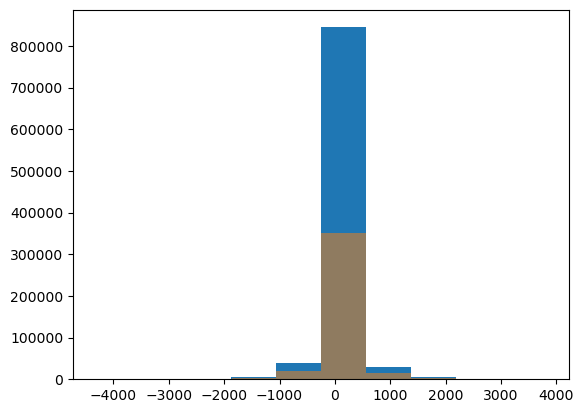

In [31]:
plt.hist(hmi_data_prev.flatten())
plt.hist(B_prev[:, :, 0, :].flatten(), alpha=0.5)
plt.show()

In [10]:
np.max(hmi_data), np.min(hmi_data)

(3417.27, -4404.7)

In [ ]:
plt.hist(hmi_data.flatten())
plt.hist(B[:, :, 0, :].flatten(), alpha=0.5)
plt.show()

In [15]:
np.max(B), np.min(B)

(10672.435, -12950.509)

In [16]:
np.max(B)/3, np.min(B)/3

(3557.4781901041665, -4316.836263020833)

In [19]:
from skimage.transform import resize

In [20]:
ox, oy, _ = hmi_data.shape
nx, ny = 512, 256

l = 0.36 # Mm

dxx = (ox * l)/nx
dyy = (oy * l)/ny
dzz = dy 

dxx, dyy, dzz = dxx * 1e8, dyy * 1e8, dzz * 1e8  # cm
dVV = dxx * dyy * dzz # cm^3

model_input = resize(hmi_data, (nx, ny, 3))
model_input = model_input[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4)
model_input.shape

(1, 1, 256, 512, 3)

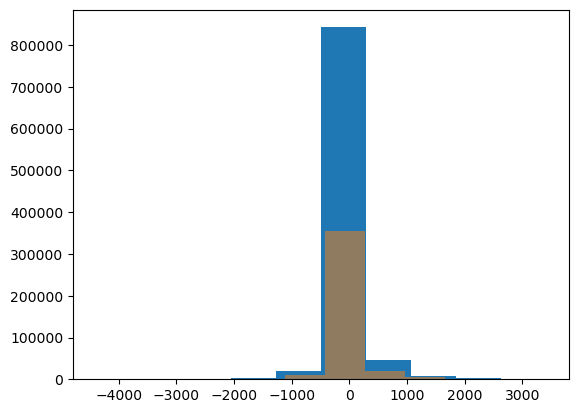

In [32]:
plt.hist(hmi_data.flatten())
plt.hist(model_input.flatten(), alpha=0.5)
plt.show()

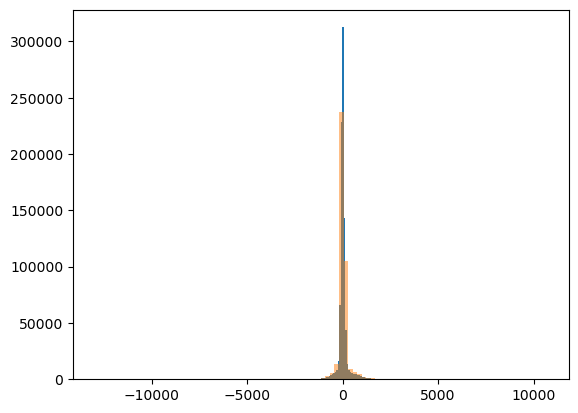

In [46]:
plt.hist(hmi_data.flatten(), bins=100)
plt.hist(B[:, :, 0, :].flatten(), alpha=0.5, bins=100)
plt.show()

In [53]:
np.unravel_index(np.argmax(hmi_data), hmi_data.shape), np.max(hmi_data)

((263, 218, 1), 3417.27)

In [54]:
np.unravel_index(np.argmin(hmi_data), hmi_data.shape), np.min(hmi_data)

((259, 256, 2), -4404.7)

In [69]:
hmi_data.shape

(688, 448, 3)

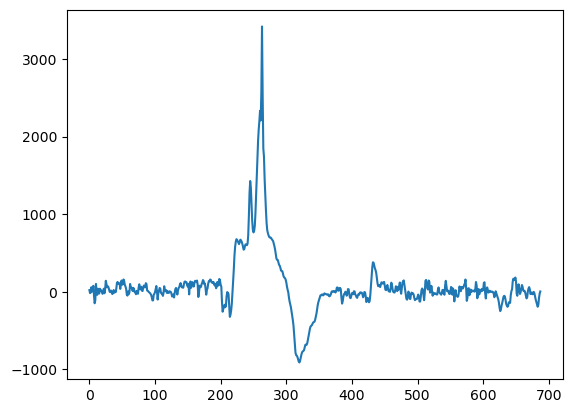

In [72]:
plt.plot(hmi_data[:, 218, 1])

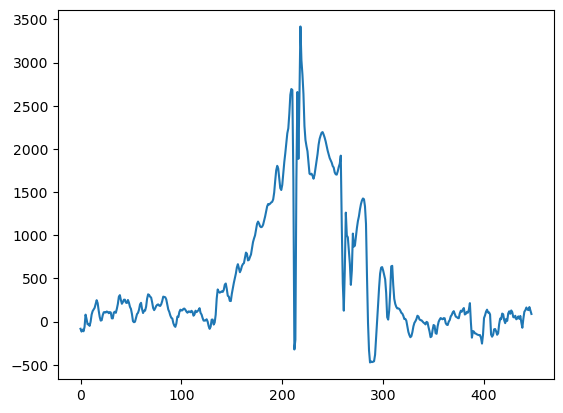

In [73]:
plt.plot(hmi_data[263, :, 1])

In [68]:
hmi_B = resize(hmi_data, (512, 256, 3))
hmi_B.shape

(512, 256, 3)

In [70]:
np.unravel_index(np.argmax(hmi_B), hmi_B.shape), np.max(hmi_B)

((196, 125, 2), 3042.2993)

In [71]:
np.unravel_index(np.argmin(hmi_B), hmi_B.shape), np.min(hmi_B)

((191, 145, 2), -3897.2097)

In [63]:
np.unravel_index(np.argmax(B), B.shape), np.max(B)

((196, 149, 0, 1), 10672.435)

In [64]:
np.unravel_index(np.argmin(B), B.shape), np.min(B)

((197, 148, 0, 2), -12950.509)

15.910199

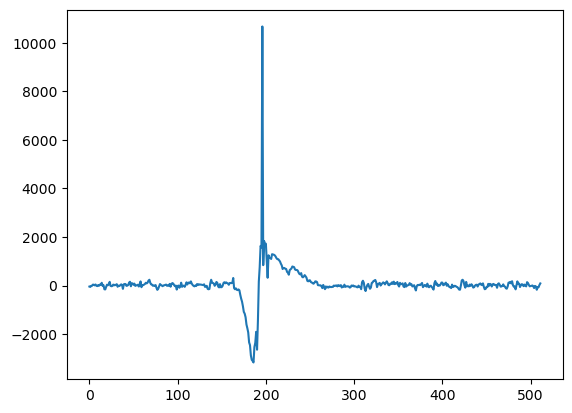

In [67]:
plt.plot(B[:, 149, 0, 1])

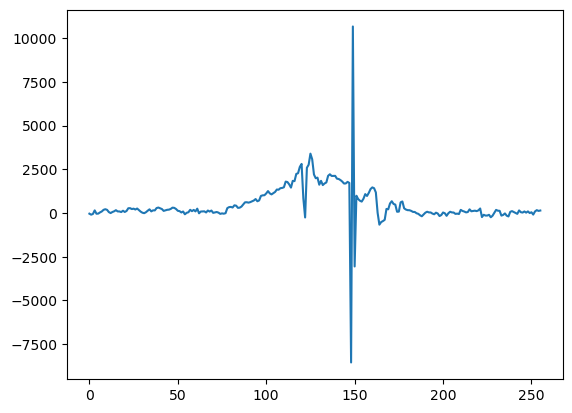

In [65]:
plt.plot(B[196, :, 0, 1])

In [58]:
B[np.unravel_index(np.argmax(B), B.shape)] = np.max(hmi_data)
B[np.unravel_index(np.argmin(B), B.shape)] = np.min(hmi_data)

In [60]:
np.unravel_index(np.argmax(B), B.shape), np.max(B)

((192, 150, 0, 1), 8747.377)

In [61]:
np.unravel_index(np.argmin(B), B.shape), np.min(B)

((196, 148, 0, 1), -8552.272)

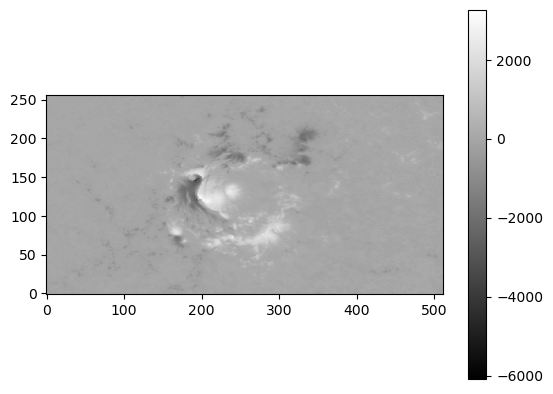

In [59]:
plt.imshow(B[:, :, 0, 2].T, origin='lower', cmap='gray')
plt.colorbar()

In [57]:
plt.imshow(BB[:, :, 0, 2].T, origin='lower', cmap='gray')
plt.colorbar()

IndexError: invalid index to scalar variable.

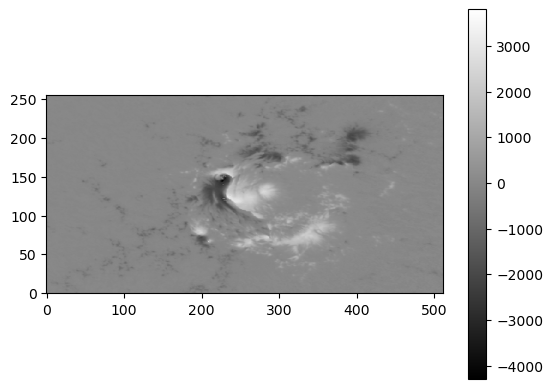

In [40]:
plt.imshow(B_prev[:, :, 0, 2].T, origin='lower', cmap='gray')
plt.colorbar()

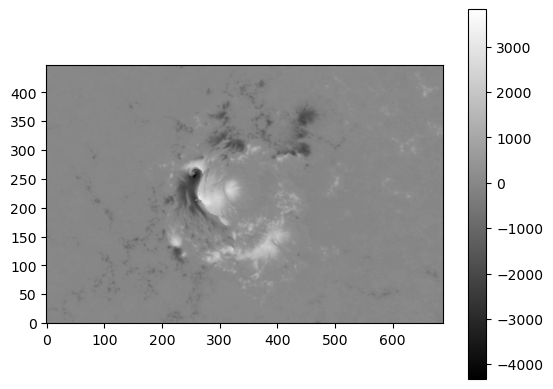

In [42]:
plt.imshow(hmi_data_prev[:, :, 2].T, origin='lower', cmap='gray')
plt.colorbar()

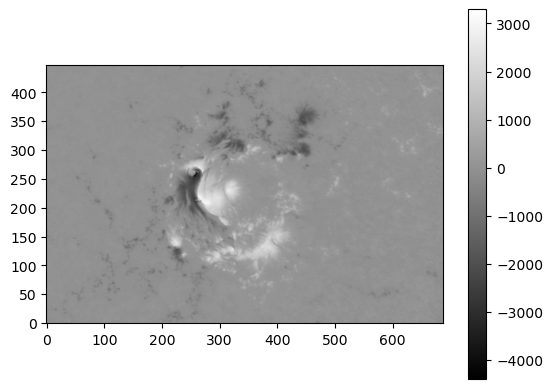

In [43]:
plt.imshow(hmi_data[:, :, 2].T, origin='lower', cmap='gray')
plt.colorbar()

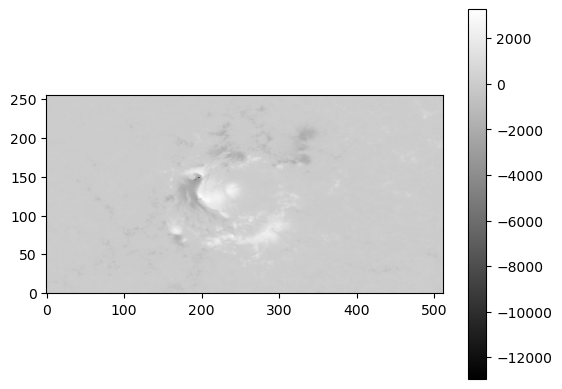

In [39]:
plt.imshow(B[:, :, 0, 2].T, origin='lower', cmap='gray')
plt.colorbar()

In [21]:
b_sharp = mm.get_pred_from_numpy(model_input)

Model loaded from epoch 75


In [23]:
res = m.evaluate(b, B)

C_vec     : 0.95
C_cs      : 0.82
E_n'      : 0.47
E_m'      : -0.25
eps       : 1.12


In [33]:
res = m.evaluate(b[:, :, 1:, :], B[:, :, 1:, :])

C_vec     : 0.94
C_cs      : 0.82
E_n'      : 0.46
E_m'      : -0.25
eps       : 1.13


In [26]:
res = m.evaluate(b_sharp, B)

C_vec     : 0.94
C_cs      : 0.82
E_n'      : 0.47
E_m'      : -0.24
eps       : 1.10


In [34]:
res = m.evaluate(b_sharp[:, :, 1:, :], B[:, :, 1:, :])

C_vec     : 0.94
C_cs      : 0.82
E_n'      : 0.46
E_m'      : -0.24
eps       : 1.12


In [66]:
((b_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev

2.622796750157728e+33

In [67]:
((B_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev

2.5448462732837308e+33

In [68]:
( ((b_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev ) / ( ((B_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev )

1.0306307212708035

In [69]:
b_prev = mm.get_pred(input_files[idx-1], b_norm="max")
B_prev = mm.get_label(label_files[idx-1])
Bp_prev = mm.get_pot(label_files[idx-1])
dx_prev, dy_prev, dz_prev, dV_prev = mm.get_dV(input_files[idx-1])
x_prev, y_prev, z_prev = mm.get_coords(label_files[idx-1])

In [70]:
res = m.evaluate(b_prev, B_prev)

C_vec     : 0.95
C_cs      : 0.76
E_n'      : 0.58
E_m'      : -0.22
eps       : 0.92


In [71]:
((b_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev

2.340702059038715e+33

In [72]:
((B_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev

2.5448462732837308e+33

In [73]:
( ((b_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev ) / ( ((B_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev )

0.9197813178783489

In [74]:
b_prev = mm.get_pred(input_files[idx-1], b_norm=4000)
B_prev = mm.get_label(label_files[idx-1])
Bp_prev = mm.get_pot(label_files[idx-1])
dx_prev, dy_prev, dz_prev, dV_prev = mm.get_dV(input_files[idx-1])
x_prev, y_prev, z_prev = mm.get_coords(label_files[idx-1])

In [75]:
res = m.evaluate(b_prev, B_prev)

C_vec     : 0.95
C_cs      : 0.77
E_n'      : 0.56
E_m'      : -0.25
eps       : 0.97


In [76]:
((b_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev

2.4561465942810563e+33

In [77]:
((B_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev

2.5448462732837308e+33

In [78]:
( ((b_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev ) / ( ((B_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev )

0.9651453685301701

In [79]:
b_prev = mm.get_pred(input_files[idx-1], clip=2500)
B_prev = mm.get_label(label_files[idx-1], clip=2500)
Bp_prev = mm.get_pot(label_files[idx-1], clip=2500)
dx_prev, dy_prev, dz_prev, dV_prev = mm.get_dV(input_files[idx-1])
x_prev, y_prev, z_prev = mm.get_coords(label_files[idx-1])

In [80]:
res = m.evaluate(b_prev, B_prev)

C_vec     : 0.95
C_cs      : 0.77
E_n'      : 0.52
E_m'      : -0.35
eps       : 1.03


In [81]:
((b_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev

2.608780071029772e+33

In [82]:
((B_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev

2.540948567668283e+33

In [83]:
( ((b_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev ) / ( ((B_prev**2).sum(-1).sum() / (8*np.pi))*dV_prev )

1.0266953468577034

In [77]:
b = mm.get_pred(input_files[idx])
B = mm.get_label(label_files[idx])
Bp = mm.get_pot(label_files[idx])
dx, dy, dz, dV = mm.get_dV(input_files[idx])
x, y, z = mm.get_coords(label_files[idx])

In [78]:
res = m.evaluate(b, B)

C_vec     : 0.95
C_cs      : 0.82
E_n'      : 0.47
E_m'      : -0.25
eps       : 1.12


In [79]:
((b**2).sum(-1).sum() / (8*np.pi))*dV

2.65463952489456e+33

In [80]:
((B**2).sum(-1).sum() / (8*np.pi))*dV

2.3735344511040267e+33

In [81]:
( ((b**2).sum(-1).sum() / (8*np.pi))*dV ) / ( ((B**2).sum(-1).sum() / (8*np.pi))*dV )

1.1184331129719984

In [82]:
b = mm.get_pred(input_files[idx], b_norm="max")
B = mm.get_label(label_files[idx])
Bp = mm.get_pot(label_files[idx])
dx, dy, dz, dV = mm.get_dV(input_files[idx])
x, y, z = mm.get_coords(label_files[idx])

In [83]:
res = m.evaluate(b, B)

C_vec     : 0.87
C_cs      : 0.41
E_n'      : 0.28
E_m'      : -0.63
eps       : 0.75


In [84]:
((b**2).sum(-1).sum() / (8*np.pi))*dV

1.772066799529399e+33

In [85]:
((B**2).sum(-1).sum() / (8*np.pi))*dV

2.3735344511040267e+33

In [86]:
( ((b**2).sum(-1).sum() / (8*np.pi))*dV ) / ( ((B**2).sum(-1).sum() / (8*np.pi))*dV )

0.7465940924957459

In [87]:
b = mm.get_pred(input_files[idx], b_norm=5000)
B = mm.get_label(label_files[idx])
Bp = mm.get_pot(label_files[idx])
dx, dy, dz, dV = mm.get_dV(input_files[idx])
x, y, z = mm.get_coords(label_files[idx])

In [88]:
res = m.evaluate(b, B)

C_vec     : 0.95
C_cs      : 0.79
E_n'      : 0.55
E_m'      : -0.05
eps       : 0.93


In [89]:
((b**2).sum(-1).sum() / (8*np.pi))*dV

2.20079831744526e+33

In [90]:
((B**2).sum(-1).sum() / (8*np.pi))*dV

2.3735344511040267e+33

In [91]:
( ((b**2).sum(-1).sum() / (8*np.pi))*dV ) / ( ((B**2).sum(-1).sum() / (8*np.pi))*dV )

0.9272240882880718

In [94]:
b = mm.get_pred(input_files[idx], clip=4000)
B = mm.get_label(label_files[idx], clip=4000)
Bp = mm.get_pot(label_files[idx], clip=4000)
dx, dy, dz, dV = mm.get_dV(input_files[idx])
x, y, z = mm.get_coords(label_files[idx])

In [95]:
res = m.evaluate(b, B)

C_vec     : 0.95
C_cs      : 0.82
E_n'      : 0.47
E_m'      : -0.24
eps       : 1.12


In [96]:
((b**2).sum(-1).sum() / (8*np.pi))*dV

2.644221666694285e+33

In [97]:
((B**2).sum(-1).sum() / (8*np.pi))*dV

2.368493660870378e+33

In [98]:
( ((b**2).sum(-1).sum() / (8*np.pi))*dV ) / ( ((B**2).sum(-1).sum() / (8*np.pi))*dV )

1.116414922437488

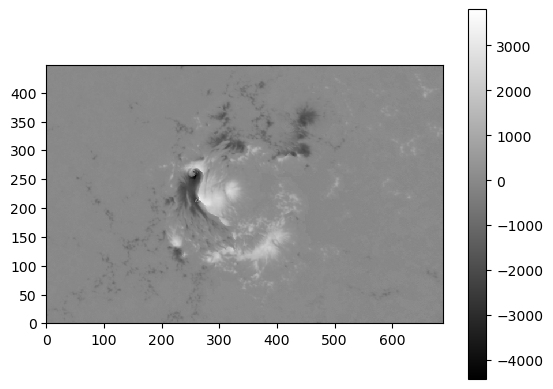

In [106]:
plt.pcolormesh(hmi_data_prev[:, :, 2].T, cmap='gray')
plt.gca().set_aspect('equal')
plt.colorbar()

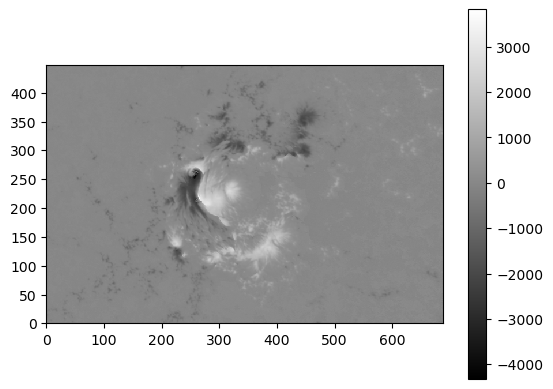

In [107]:
plt.pcolormesh(hmi_data[:, :, 2].T, cmap='gray')
plt.gca().set_aspect('equal')
plt.colorbar()

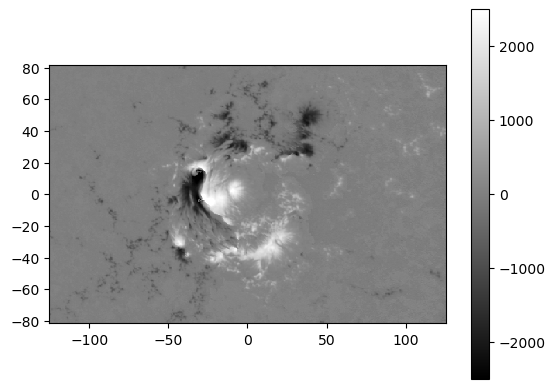

In [108]:
plt.pcolormesh(x_prev, y_prev, B_prev[:, :, 0, 2].T, cmap='gray')
plt.gca().set_aspect('equal')
plt.colorbar()

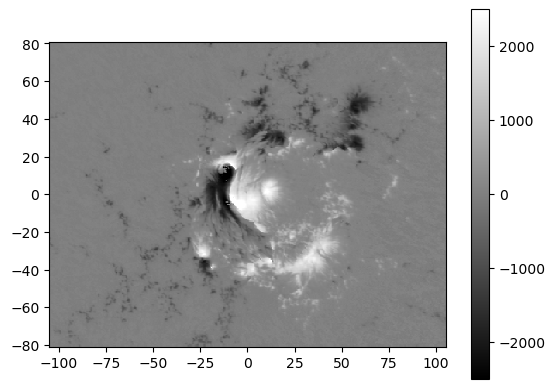

In [109]:
plt.pcolormesh(x, y, B[:, :, 0, 2].T, cmap='gray')
plt.gca().set_aspect('equal')
plt.colorbar()

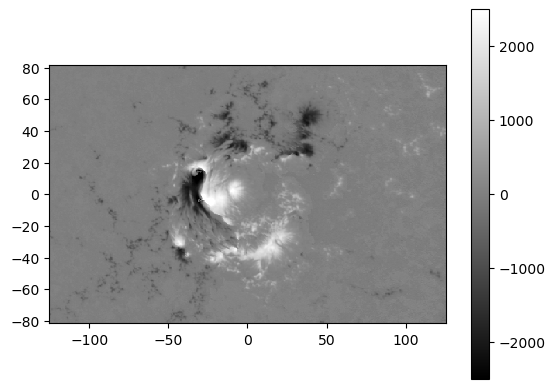

In [110]:
plt.pcolormesh(x_prev, y_prev, Bp_prev[:, :, 0, 2].T, cmap='gray')
plt.gca().set_aspect('equal')
plt.colorbar()

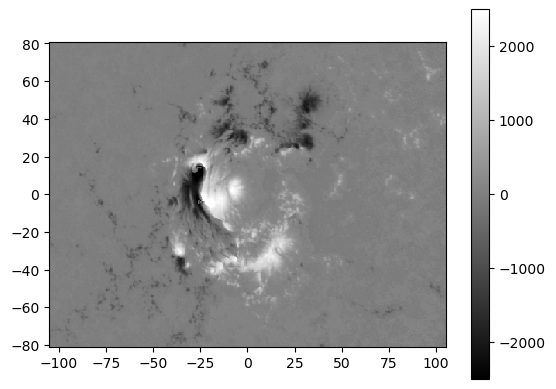

In [111]:
plt.pcolormesh(x, y, Bp_prev[:, :, 0, 2].T, cmap='gray')
plt.gca().set_aspect('equal')
plt.colorbar()